**Подготавливаем данные для анализа**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! 7z e '/content/drive/My Drive/data.zip' -oA1_train       train_images/*.jpg
! 7z e '/content/drive/My Drive/data.zip' -oA3_trainlabels train.csv


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/My Drive/                                  1 file, 1684204253 bytes (1607 MiB)

Extracting archive: /content/drive/My Drive/data.zip
 22% 4096 Open              --
Path = /content/drive/My Drive/data.zip
Type = zip
Physical Size = 1684204253

  0%    
Would you like to replace the existing file:
  Path:     A1_train/0002cc93b.jpg
  Size:     115633 bytes (113 KiB)
  Modified: 2019-12-11 23:23:50
with the file from archive:
  Path:     train_images/0002cc93b.jpg
  Size:     115633 bytes (113 KiB)
  Modified: 2019-12-11 23:23:50
? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? a

  0% - train_images/0002cc93b.jpg

**С помощью имен изображений из папки train_images и данных из train.csv подготовим dataframe, который потребуется нам в дальнейшем для анализа данных и при обучении**

In [ ]:
import numpy as np
import os
import pandas as pd

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import seaborn as sns
import cv2

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
train_path = '/content/A1_train/'
train_image_names = os.listdir(train_path)
trainLabels = pd.read_csv('/content/A3_trainlabels/train.csv')

In [ ]:
tr_img_id = []
tr_cls_id = []
for i in os.listdir(train_path):
    tr_img_id.append(i)
    tr_cls_id.append(1)
    tr_img_id.append(i)
    tr_cls_id.append(2)
    tr_img_id.append(i)
    tr_cls_id.append(3)
    tr_img_id.append(i)
    tr_cls_id.append(4)
train_img_nms = pd.DataFrame(tr_img_id,columns=['ImageId'])
train_img_nms['ClassId'] = tr_cls_id
train_img_nms.head()

,ImageId,ClassId
0,96a0c2754.jpg,1
1,96a0c2754.jpg,2
2,96a0c2754.jpg,3
3,96a0c2754.jpg,4
4,375a5eb85.jpg,1


In [ ]:
train_df = pd.merge(train_img_nms, trainLabels,how='outer',on=['ImageId','ClassId'])
train_df = train_df.fillna('')
train_df.head()

,ImageId,ClassId,EncodedPixels
0,96a0c2754.jpg,1,
1,96a0c2754.jpg,2,
2,96a0c2754.jpg,3,
3,96a0c2754.jpg,4,
4,375a5eb85.jpg,1,


In [ ]:
train_data = pd.pivot_table(train_df, values='EncodedPixels', index='ImageId',columns='ClassId', aggfunc=np.sum).astype(str)
train_data = train_data.reset_index()
train_data.columns = ['ImageId','Defect_1','Defect_2','Defect_3','Defect_4']
train_data.head()

,ImageId,Defect_1,Defect_2,Defect_3,Defect_4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,
1,00031f466.jpg,,,,
2,000418bfc.jpg,,,,
3,000789191.jpg,,,,
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,


In [ ]:
tmp = []
for i in range(len(train_data)):
    if all((train_data['Defect_1'][i]=='',train_data['Defect_2'][i]=='',train_data['Defect_3'][i]=='',train_data['Defect_4'][i]=='')):
        tmp.append(0)
    else:
        tmp.append(1)
train_data['hasDefect'] = tmp

tmp = []
for i in range(len(train_data)):
    if train_data['Defect_1'][i]=='':
        tmp.append(0)
    else:
        tmp.append(1)
train_data['hasDefect_1'] = tmp

tmp = []
for i in range(len(train_data)):
    if train_data['Defect_2'][i]=='':
        tmp.append(0)
    else:
        tmp.append(1)
train_data['hasDefect_2'] = tmp

tmp = []
for i in range(len(train_data)):
    if train_data['Defect_3'][i]=='':
        tmp.append(0)
    else:
        tmp.append(1)
train_data['hasDefect_3'] = tmp

tmp = []
for i in range(len(train_data)):
    if train_data['Defect_4'][i]=='':
        tmp.append(0)
    else:
        tmp.append(1)
train_data['hasDefect_4'] = tmp

train_data[0:3]

,ImageId,Defect_1,Defect_2,Defect_3,Defect_4,hasDefect,hasDefect_1,hasDefect_2,hasDefect_3,hasDefect_4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,,1,1,0,0,0
1,00031f466.jpg,,,,,0,0,0,0,0
2,000418bfc.jpg,,,,,0,0,0,0,0


**Анализ данных**

Пример изображения:

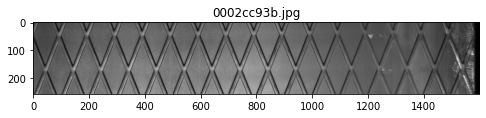

(1600, 256)


In [ ]:
# Sample Image
fig, ax = plt.subplots(1,1,figsize=(8, 7))
img = Image.open(str(train_path + train_data.ImageId.iloc[3]))
plt.imshow(img)
ax.set_title(train_data.ImageId.iloc[0])
plt.show()
print(img.size)

Изображения имеют размер 1600 x 256

Количество изображений:  12568 



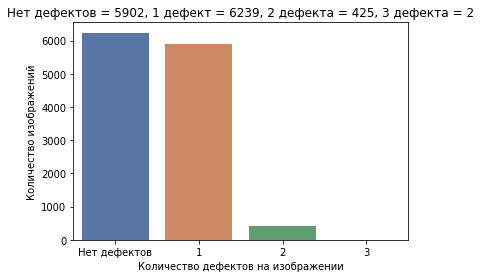

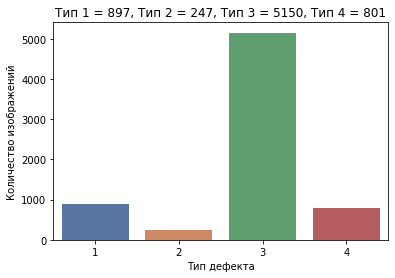

In [ ]:
print("Количество изображений: ", train_data.shape[0],'\n')

tmp = (train_data['hasDefect_1']+train_data['hasDefect_2']+train_data['hasDefect_3']+train_data['hasDefect_4']).value_counts()
fig, ax = plt.subplots()
sns.barplot(x=['Нет дефектов','1','2','3'],y=tmp,palette = "deep")
ax.set_title("Нет дефектов = {}, 1 дефект = {}, 2 дефекта = {}, 3 дефекта = {}".format(tmp[0],tmp[1],tmp[2], tmp[3]))
ax.set_ylabel('Количество изображений')
ax.set_xlabel('Количество дефектов на изображении')
plt.show()

tmp = [sum(train_data['hasDefect_1']==1),
       sum(train_data['hasDefect_2']==1),
       sum(train_data['hasDefect_3']==1),
       sum(train_data['hasDefect_4']==1)]
fig, ax = plt.subplots()
sns.barplot(x=['1','2','3','4'],y=tmp,palette = "deep")
ax.set_title("Тип 1 = {}, Тип 2 = {}, Тип 3 = {}, Тип 4 = {}".format(tmp[0],tmp[1],tmp[2],tmp[3]))
ax.set_ylabel('Количество изображений')
ax.set_xlabel('Тип дефекта')
plt.show()

**Вывод: Набор данных сильно несбалансирован относительно типов дефектов, второй тип имеет очень мало изображений. При этом количество изображений без дефектов и с дефектами примерно равны.**

Примеры изображений без дефектов:


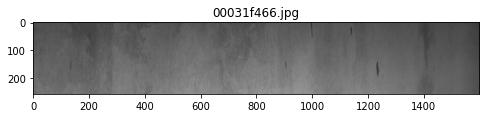

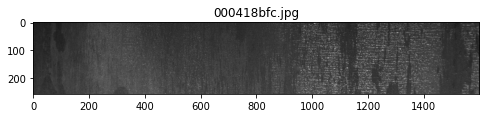

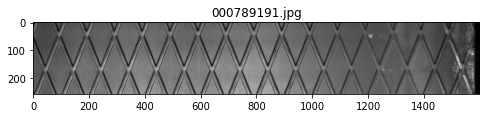

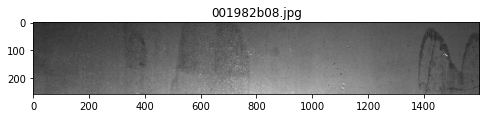

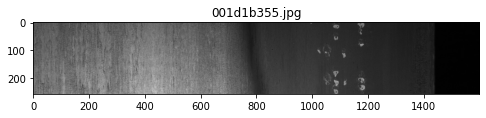

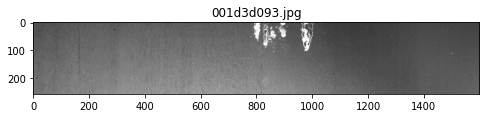

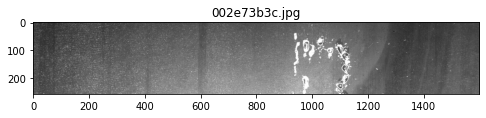

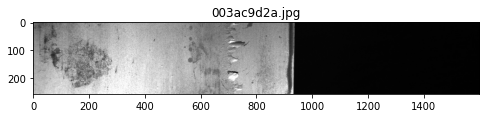

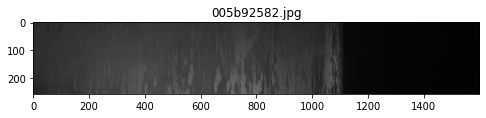

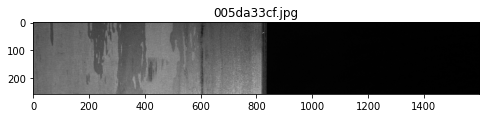

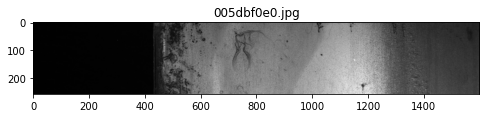

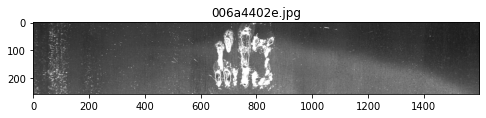

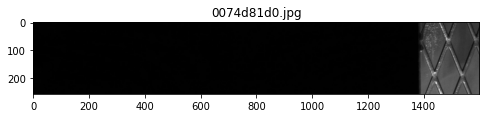

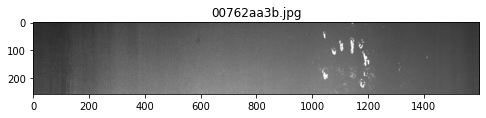

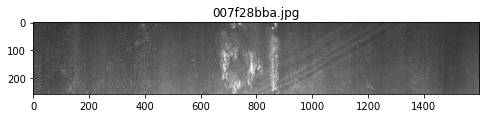

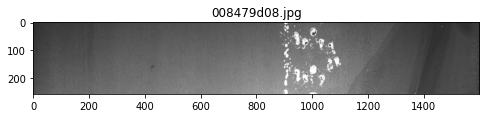

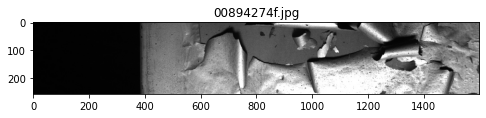

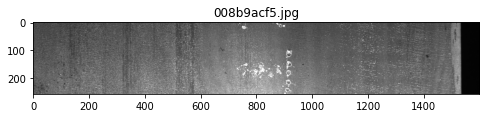

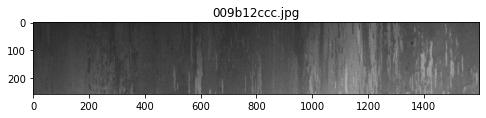

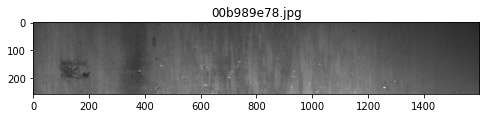

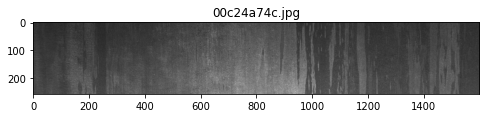

In [ ]:
tmp = []
cnt=0
print("Примеры изображений без дефектов:")
for i in train_data['ImageId'][train_data['hasDefect']==0]:
    if cnt<21:
        fig, ax = plt.subplots(1,1,figsize=(8, 7))
        img = Image.open(str(train_path + i))
        plt.imshow(img)
        ax.set_title(i)
        plt.show()
        cnt+=1

Примеры изображений с дефектами:


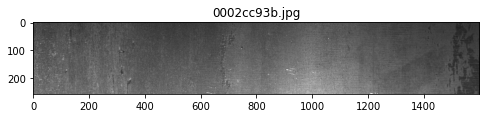

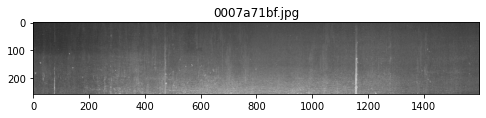

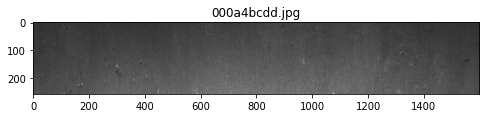

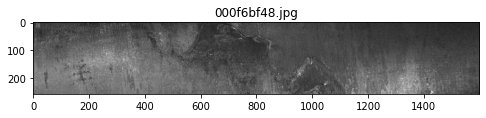

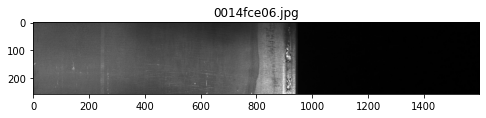

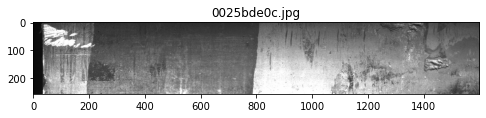

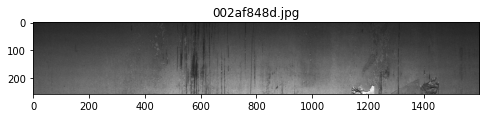

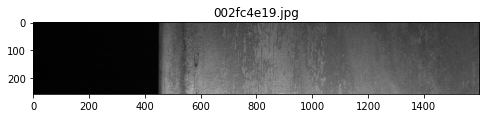

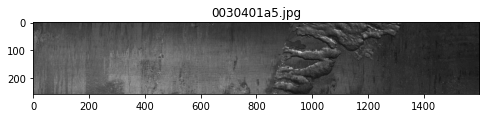

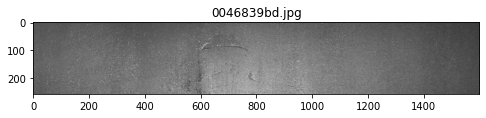

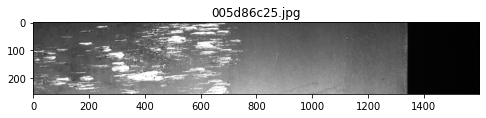

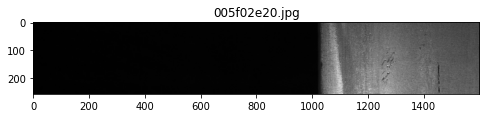

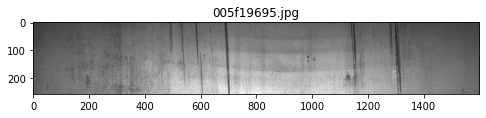

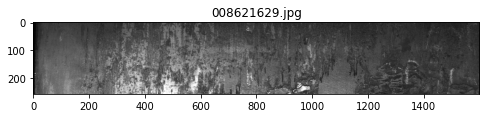

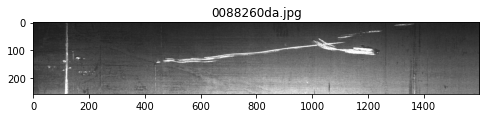

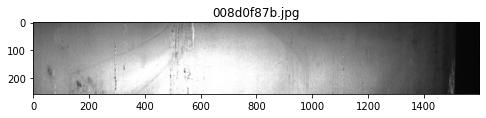

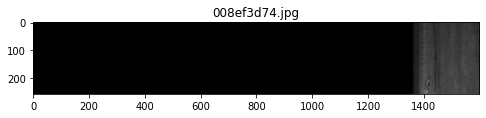

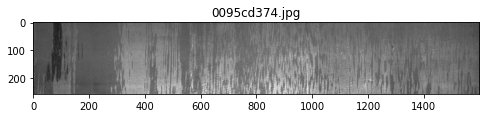

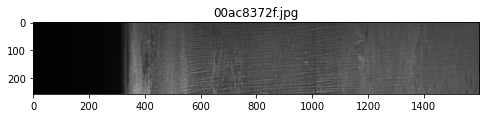

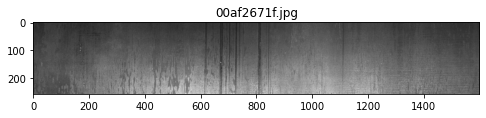

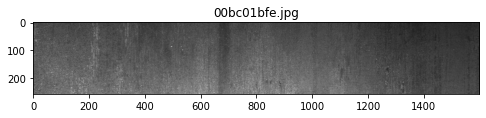

In [ ]:
tmp = []
cnt=0
print("Примеры изображений с дефектами:")
for i in train_data['ImageId'][train_data['hasDefect']==1]:
    if cnt<21:
        fig, ax = plt.subplots(1,1,figsize=(8, 7))
        img = Image.open(str(train_path + i))
        plt.imshow(img)
        ax.set_title(i)
        plt.show()
        cnt+=1

In [ ]:

def rle2mask(mask_rle, shape=(1600,256)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2rle(img):
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

Изображения с деффектами:

Sample images with Class 1 defect:


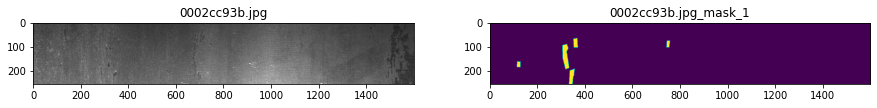

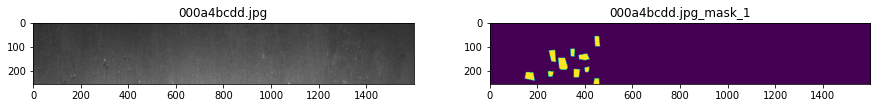

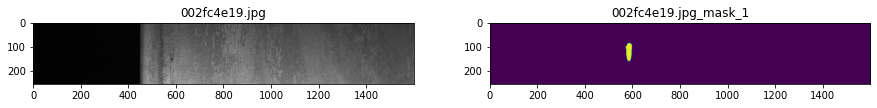

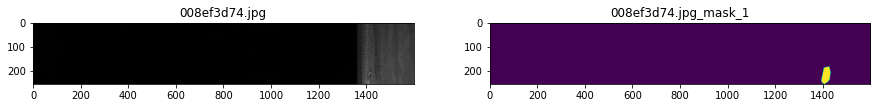

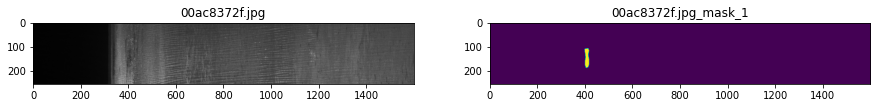

--------------------------------------------------------------------------------
Sample images with Class 2 defect:


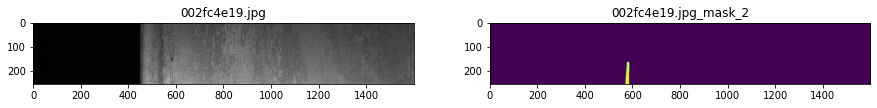

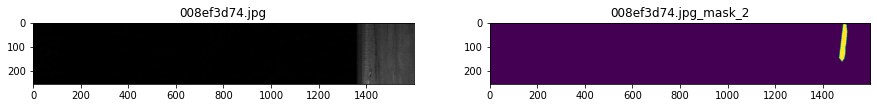

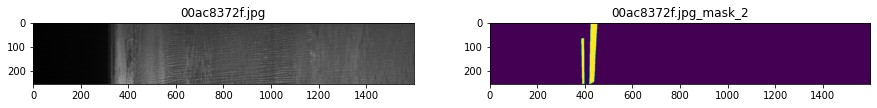

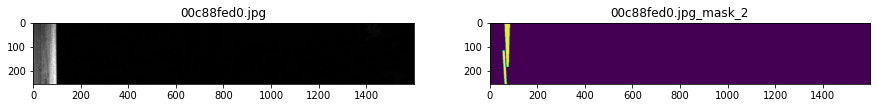

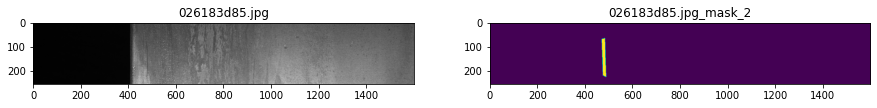

--------------------------------------------------------------------------------
Sample images with Class 3 defect:


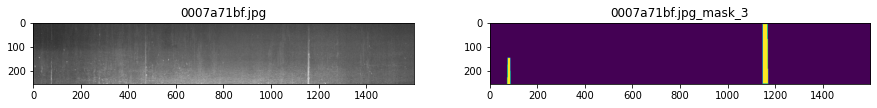

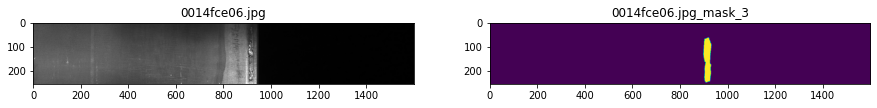

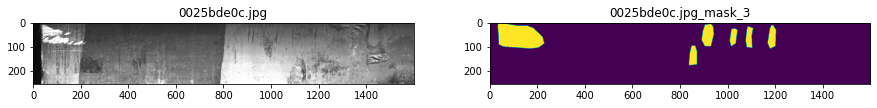

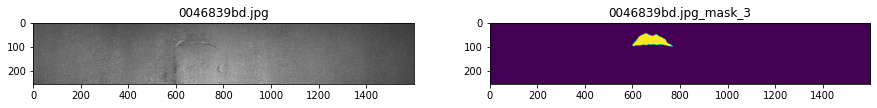

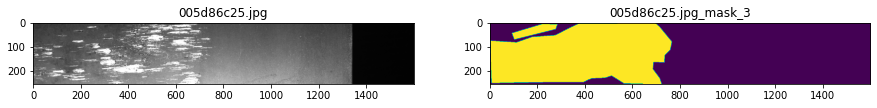

--------------------------------------------------------------------------------
Sample images with Class 4 defect:


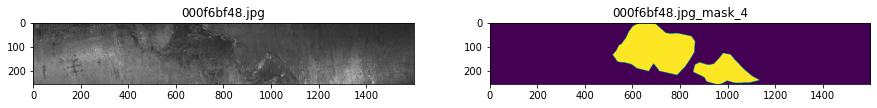

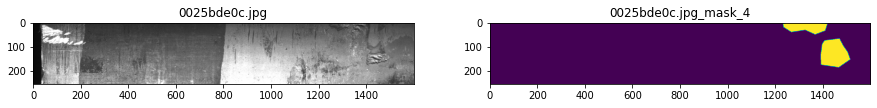

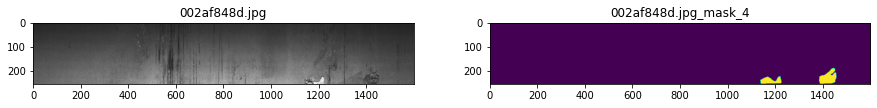

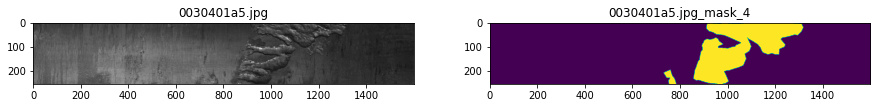

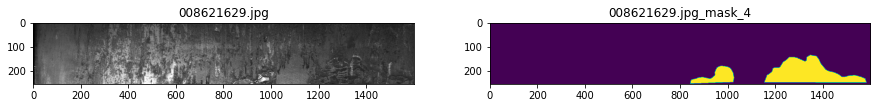

--------------------------------------------------------------------------------


In [ ]:
for k in [1,2,3,4]:
    tmp = []
    cnt=0
    print("Sample images with Class {} defect:".format(k))
    for i in train_data[train_data[f'hasDefect_{k}']==1][['ImageId',f'Defect_{k}']].values:
        if cnt<5:
            fig, (ax1,ax2) = plt.subplots(nrows = 1,ncols = 2,figsize=(15, 7))
            img = Image.open(str(train_path + i[0]))
            ax1.imshow(img)
            ax1.set_title(i[0])
            cnt+=1
            ax2.imshow(rle2mask(i[1]))
            ax2.set_title(i[0]+'_mask_'+str(k))
            plt.show()
    print('-'*80)

Попробуем разделить нашу задачу на 2 этапа:
1. Создадим простой бинарный классификатор, который будет предсказывать, есть ли хоть один дефект на изображении или нет. Это позовлит отсеять изображения без дефектов для следующего этапа
2. Реализуем сеть на базе Unet для предсказания маски дефекта

**Этап 1: Бинарный классификатор на базе CNN**


In [ ]:
X = train_data.copy()
X['hasDefect'] = X['hasDefect'].astype(str)
X_train, X_test = train_test_split(X, test_size = 0.1, stratify = X['hasDefect'],random_state=3)
X_train, X_val = train_test_split(X_train, test_size = 0.2, stratify = X_train['hasDefect'],random_state=3)
print(X_train.shape, X_val.shape, X_test.shape)

(9048, 10) (2263, 10) (1257, 10)


In [ ]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv2D(8, (3, 3), activation="relu", 
                       input_shape=(256, 256, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(16, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation="relu")) 
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation="relu"))

model.add(layers.Dropout(0.2)) 
model.add(layers.Dense(256, activation="relu"))

model.add(layers.Dropout(0.2)) 
model.add(layers.Dense(128, activation="relu"))

model.add(layers.Dense(1, activation='sigmoid'))

Using TensorFlow backend.


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 8)       224       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 127, 127, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 125, 125, 16)      1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 32)        4640      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 64)       

In [ ]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.1,
    fill_mode='constant',
    rotation_range=10,
    height_shift_range=0.1,
    width_shift_range=0.1,
    cval=0.,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = train_datagen.flow_from_dataframe(dataframe=X_train, directory=train_path, 
                                        x_col="ImageId", y_col="hasDefect", 
                                        class_mode="binary", target_size=(256, 256), batch_size=64)

validation_generator = train_datagen.flow_from_dataframe(dataframe=X_val, directory=train_path, 
                                        x_col="ImageId", y_col="hasDefect", 
                                        class_mode="binary", target_size=(256, 256), batch_size=64)

Found 9048 validated image filenames belonging to 2 classes.
Found 2263 validated image filenames belonging to 2 classes.


In [ ]:
step_size=np.ceil(train_generator.n/train_generator.batch_size)
step_size_val=np.ceil(validation_generator.n/validation_generator.batch_size)
history = model.fit_generator(
    train_generator,
    steps_per_epoch = step_size,
    epochs = 25,
    validation_data = validation_generator,
    validation_steps = step_size_val
    )

model.save('/content/drive/My Drive/binary.h5')


Epoch 1/25
142/142 [==============================] - 245s 2s/step - loss: 0.6316 - accuracy: 0.6375 - val_loss: 0.5587 - val_accuracy: 0.6929
Epoch 2/25
142/142 [==============================] - 219s 2s/step - loss: 0.5745 - accuracy: 0.6910 - val_loss: 0.5948 - val_accuracy: 0.7004
Epoch 3/25
142/142 [==============================] - 221s 2s/step - loss: 0.5488 - accuracy: 0.7157 - val_loss: 0.5303 - val_accuracy: 0.7318
Epoch 4/25
142/142 [==============================] - 222s 2s/step - loss: 0.5278 - accuracy: 0.7331 - val_loss: 0.4455 - val_accuracy: 0.7742
Epoch 5/25
142/142 [==============================] - 219s 2s/step - loss: 0.4803 - accuracy: 0.7649 - val_loss: 0.3559 - val_accuracy: 0.7866
Epoch 6/25
142/142 [==============================] - 220s 2s/step - loss: 0.4466 - accuracy: 0.7817 - val_loss: 0.4413 - val_accuracy: 0.7782
Epoch 7/25
142/142 [==============================] - 221s 2s/step - loss: 0.4239 - accuracy: 0.7997 - val_loss: 0.3342 - val_accuracy: 0.8051

Text(0, 0.5, 'Значение метрики')

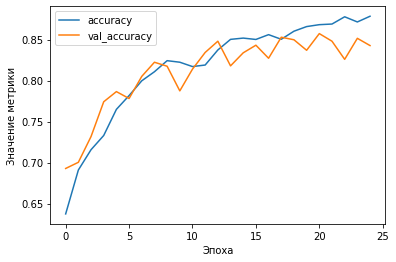

In [ ]:
history_df = pd.DataFrame(history.history)
ax = history_df[['accuracy', 'val_accuracy']].plot()
ax.set_xlabel("Эпоха")
ax.set_ylabel("Значение метрики")

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(dataframe=X_test, directory=train_path,  
                                        x_col="ImageId", y_col="hasDefect", 
                                        class_mode="binary", target_size=(256, 256), batch_size=32)

step_size_test=np.ceil(test_generator.n/test_generator.batch_size)
test_loss, test_acc = history.model.evaluate_generator(test_generator, steps = step_size_test)
print('test acc:', test_acc)

Found 1257 validated image filenames belonging to 2 classes.
test acc: 0.8758949637413025
